---
layout: post
title:  "Training a Neural Network Embedding Layer with Keras"
desc: "Using python, Keras and some colours to illustrate encoding as simply as possible"
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/encoding_colours"

---

This little write is designed to try and explain what **embeddings** are, and how we can train a naive version of an embedding to understand and visualise the process. We'll do this using a colour dataset, Keras and good old-fashioned matplotlib.

# Introduction

Let's start simple: *What is an embedding?*

An embedding is a way to represent some categorical feature (like a word), as a dense parameter. Specifically, this is normally a unit vector in a high dimensional hypersphere. 

A common way of encoding a categorical feature of machine learning is to one-hot-encode them. However, for a large number of categories, this creates a very spare matrix. Imagine encoding the names of babies born in 2020. You might have a million records, but with ten thousand possible names, that is a **very** big matrix filled with mostly zeros. Also, names like Mat and Matt are just as similar as Mat and Patrica when you one-hot-encode. That is, not similar at all. 

Instead, if we can create a dense vector (aka a vector filled with numbers and not mostly zeros), we can represent Mat, Matt and Patrica as some location in higher dimensional space, where the Mat and Matt vectors are similar to each other. This is what we are trying to do with embeddings. To learn the translation from a categorical feature to this vector in higher dimensional space.

Most of the time when you use embeddings, you'll use them already trained and available - you won't be training them yourself. However, to understand what they are better, we'll mock up a dataset based on colour combinations, and learn the embeddings to turn a colour name into a location in both 2D and 3D space.

So, for the rest of this write up, the goal is to:

1. Start with some colours.
2. Create a data product similar to how Word2Vec and others embeddings are trained.
3. Create a model with a 2D embedding layer and train it.
4. Visualise the embedding layer.
5. Do the same for a 3D normalised embedding just for fun.

Let's get cracking!

# The colour dataset

We'll source the colour dataset available from [Kaggle here](https://www.kaggle.com/ravikanth/colour-name-and-rgb-codes). Let's load it in and view a few samples from it.

In [1]:
# Remove
from base import *
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#eb9834', '#d60921', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

In [2]:
import pandas as pd
import numpy as np

df_original = pd.read_csv("encoding_colours/colours.csv")
df_original = df_original.dropna(subset=["Color Name"])
num_colours = df_original.shape[0]
print(f"We have {num_colours} colours")
df_original.sample(5)

We have 646 colours


,Color Name,Credits,R;G;B Dec,RGB Hex,CSS Hex,BG/FG color sample
454,VioletRed1,X,255;62;150,FF3E96,NaN,### SAMPLE ###
297,DarkKhaki,X,189;183;107,BDB76B,NaN,### SAMPLE ###
276,chocolate2,X,238;118;33,EE7621,NaN,### SAMPLE ###
522,maroon2,X,238;48;167,EE30A7,NaN,### SAMPLE ###
480,tomato4,X,139;54;38,8B3626,NaN,### SAMPLE ###


So after dropping NaNs, we have 646 different colour names. Lets throw out columns we don't want, and split the R;G;B Dec into separate columns (and then normalise them to 1).

In [3]:
df = df_original.loc[:, ["Color Name", "R;G;B Dec"]]
df[["r", "g", "b"]] = df["R;G;B Dec"].str.split(";", expand=True).astype(int) / 255
df = df.drop(columns="R;G;B Dec")
df = df.rename(columns={"Color Name": "name"})
df = df.reset_index(drop=True)
df.sample(10)

,name,r,g,b
483,LavenderBlush,1.000000,0.941176,0.960784
562,ivory2,0.933333,0.933333,0.878431
462,red4,0.545098,0.000000,0.000000
168,PaleTurquoise2,0.682353,0.933333,0.933333
449,firebrick3,0.803922,0.149020,0.149020
219,turquoise2,0.000000,0.898039,0.933333
553,NavajoWhite1,1.000000,0.870588,0.678431
411,HotPink1,1.000000,0.431373,0.705882
177,RoyalBlue5,0.000000,0.133333,0.400000
281,Very Dark Brown,0.360784,0.250980,0.200000


Now theres just one more issue - you dont pass in strings or text to a neural network. You pass in numbers. So lets one-hot encode our colours to give them a numeric representation. We *could* use the Keras preprocessing `one_hot` here... but we've got this nice dataframe which already has an index... so we'll use that, and I'll make it explicit and add it as a column.


In [4]:
df["num"] = df.index
df.head(10)

,name,r,g,b,num
0,Grey,0.329412,0.329412,0.329412,0
1,"Grey, Silver",0.752941,0.752941,0.752941,1
2,grey,0.745098,0.745098,0.745098,2
3,LightGray,0.827451,0.827451,0.827451,3
4,LightSlateGrey,0.466667,0.533333,0.600000,4
5,SlateGray,0.439216,0.501961,0.564706,5
6,SlateGray1,0.776471,0.886275,1.000000,6
7,SlateGray2,0.725490,0.827451,0.933333,7
8,SlateGray3,0.623529,0.713725,0.803922,8
9,SlateGray4,0.423529,0.482353,0.545098,9


At this point, we have a nice data product, but it doesn't look like how you might train embeddings for words.

Words don't have a well defined mathematical representation to start with, instead we simply see certain words next to each other (or close to each other) more often, and we learn from that. So lets start by generating pairs of colours to emulate pairs of sequential words in what is now a colour-palette-like example.

In [5]:
n = 100000 # Num samples
colour_1 = df.sample(n=n, replace=True, random_state=0).reset_index(drop=True)
colour_2 = df.sample(n=n, replace=True, random_state=42).reset_index(drop=True)
c = colour_1.merge(colour_2, left_index=True, right_index=True)
c[["name_x", "name_y"]].sample(10)

,name_x,name_y
77810,VioletRed1,DarkSeaGreen
51407,magenta,VioletRed3
78627,tan2,grey0
76338,grey66,brown
25533,RoyalBlue5,gold4
33303,Medium Wood,grey43
67564,magenta,DarkOliveGreen1
14346,Neon Blue,grey27
88983,grey25,turquoise4
21582,CSS Gold,plum


Great! A hundred thousand colour combinations. However, this is still useless. When we train embeddings on words, we want positive **and** negative examples. 

In a textual example, the pairs that come from words being next to each other are positive examples. We can generate negative examples by scrambling the document to remove meaning, and then taking pairs (of course, there many formal methods of doing this that I'm not going to go into!).

In our case, we'll define a similarity metric ourselves, by just using the distance the two colours are from each other.

In [6]:
# Calculate the distance, and drop the RGB columns.
c["diff"] = ((c.r_x - c.r_y)**2 + (c.g_x - c.g_y)**2 + (c.b_x - c.b_y)**2) / 3
c = c.drop(columns=["r_x", "r_y", "g_x", "g_y", "b_x", "b_y"])
c

,name_x,num_x,name_y,num_y,diff
0,gainsboro,559,grey91,102,0.002215
1,Goldenrod,629,OrangeRed4,435,0.266913
2,SteelBlue4,192,tan2,270,0.210832
3,DarkSalmon,359,grey95,106,0.117621
4,SlateGray4,9,grey60,71,0.015999
...,...,...,...,...,...
99995,grey65,76,Very Dark Brown,281,0.149199
99996,SkyBlue2,180,DarkOrchid2,479,0.105908
99997,LemonChiffon2,592,purple1,525,0.231757
99998,cornsilk1,609,grey74,85,0.045101


Now that we have a difference, lets turn that into a set of positive and negative examples. I'm just going to compare the difference to a random number, and you can see this will generate a bunch of predicted values of 1 and 0.

In [7]:
np.random.seed(0)
c["predict"] = (c["diff"] < 0.2 * np.random.random(c.shape[0]) ** 2).astype(int)
print(f"{100 * c.predict.mean(): 0.1f}% positive values")
c.sample(10)

 22.5% positive values


,name_x,num_x,name_y,num_y,diff,predict
63834,LightYellow1,602,burlywood1,257,0.034330,0
12504,Dusty Rose,468,VioletRed3,444,0.041143,1
48828,salmon1,393,Free Speech Green,352,0.410821,0
32737,orange3,390,grey89,100,0.311926,0
97626,red4,462,grey44,55,0.132344,1
31753,grey57,68,grey78,89,0.044844,0
81431,DarkSeaGreen4,296,burlywood3,259,0.058239,1
32403,grey15,26,BlueViolet,117,0.232572,0
62143,DarkOliveGreen1,287,SlateBlue4,187,0.286633,0
99415,MistyRose2,428,SkyBlue1,179,0.065016,1


Its common to have more negative values than positive, both because you can generate essentially infinite negative values (just keep sticking random words together for text), so I've made sure to have around a quarter positive values here. You can generate whatever ratio you like, it won't actually change how the rest of this example runs.

Now that we have a training dataset, let's make a Keras model!

In [8]:
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, Lambda, Input, Subtract
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback

def sum_dist(x):
    n = K.permute_dimensions(x, pattern=(1, 0, 2))
    a, b = n[0], n[1]
    return K.sum((a - b)**2, axis=-1, keepdims=True)

def get_model(embedding_dims=2):
    model = keras.Sequential()
    model.add(Embedding(num_colours, embedding_dims, input_length=2))
    model.add(Lambda(sum_dist, output_shape=(1,), name="Dist"))
    model.add(Dense(1, activation="sigmoid"))
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["mse"])
    return model

def setseed(i):
    np.random.seed(i), set_seed(i)

Okay, lets step through this. In `get_model` we ask for a normal sequential model. The `Embedding` layer is a lookup table, which will have 646 rows (one for each colour), and will produce a 2D vector for each word. Because we generate two words at a time, we set `input_length=2` - which means the output of the embeding layer will be 2 2D vectors (aka a matrix of shape `(2,2)`). 

If you don't want to combine the inputs together like I am doing, [here](https://stackoverflow.com/questions/53356849/how-to-train-a-model-with-only-an-embedding-layer-in-keras-and-no-labels) is an example where the model has two separate inputs that are combined later.

After the embedding, we have a `Lambda` layer, which simply takes that `2x2` matrix from the embedding output, splits it into `a` and `b` (the embedding vector for each of our two colours), and then returns the sum of the squared difference. Which is the Euclidean distance squared. 

The keen-eyed among you might remember that we set a positive value for our predict column before for similar vectors... and here similar vectors will have a result close to zero! 

It doesn't matter! 

The reason we don't care, is because the `Lambda` layer is connected to a single `Dense` layer, which will also train its weight and bias. If the weight is negative and bias positive, it will act as an inverting mechanism. Neural networks really are magic!

If this still upsets you though, you can change out the `K.sum`, but a naive invert will cause division by zero. To get around it, you could use Lidstone smoothing (aka add a number to the denominator so its never zero), but I digress.

Finally, to make sure I can reproduce these plots exactly, I added the `setseed` function.

Lets now instantiate the model, and fit it. Oh, I'll also save out the embedding weights using a custom callback as we go, so that we can see their evolution over epochs. 

In [9]:
weights = []
save = LambdaCallback(on_epoch_end=lambda batch, logs: 
                      weights.append(model.layers[0].get_weights()[0]))

X, y = c[["num_x", "num_y"]], c["predict"]

setseed(7)
model = get_model()
model.fit(X, y, epochs=500, verbose=0, batch_size=512, callbacks=[save]);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 2)              1292      
_________________________________________________________________
Dist (Lambda)                (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 1,294
Trainable params: 1,294
Non-trainable params: 0
_________________________________________________________________
None


**Warning: nastly plotting code below.**

Now that we have a trained model, lets see how it performed. Below is an animation of the embeddings evolving.

In [29]:
%%capture
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Get the list of colours
cs = df[["r", "g", "b"]].to_numpy()

# Create the plots
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9)
ax.set_xlabel("$x_0$"), ax.set_ylabel("$x_1$")
ax.set_title("Training of 2D colour embeddings")
scat = ax.scatter(weights[-1][:, 0], weights[-1][:, 1], color=cs, s=10);

def init():
    ax.set_xlim(weights[-1][:,0].min(), weights[-1][:,0].max())
    ax.set_ylim(weights[-1][:,1].min(), weights[-1][:,1].max())
    return scat,
def update(i):
    scat.set_offsets(weights[i])
    return scat,

# Split our epochs into frames
nw = len(weights) - 1
nf, power = 30 * 10, 2
frames = pd.unique((np.linspace(1, nw**(1 / power), nf)**power).astype(int))
ani = FuncAnimation(fig, update, frames=frames, 
                    init_func=init, blit=True, interval=33.3);

In [30]:
from IPython.display import Video
ani.save('encoding_colours/embed_2d.mp4', fps=30, 
         extra_args=['-vcodec', 'libx264'])
Video("encoding_colours/embed_2d.mp4")

# If you're running this in a Jupyter notebook, the below will do the 
# same without saving it to file
# HTML(ani.to_html5_video())

This is beautiful. From the starting randomly initialised mess, quickly structure emerges. You can see the black to white gradient down the middle, with blue and red being split on either side. Green, being in between and limited by 2D space, gets stuck in between. 

And to give you something that isn't moving to look at better, here is the final embedding.

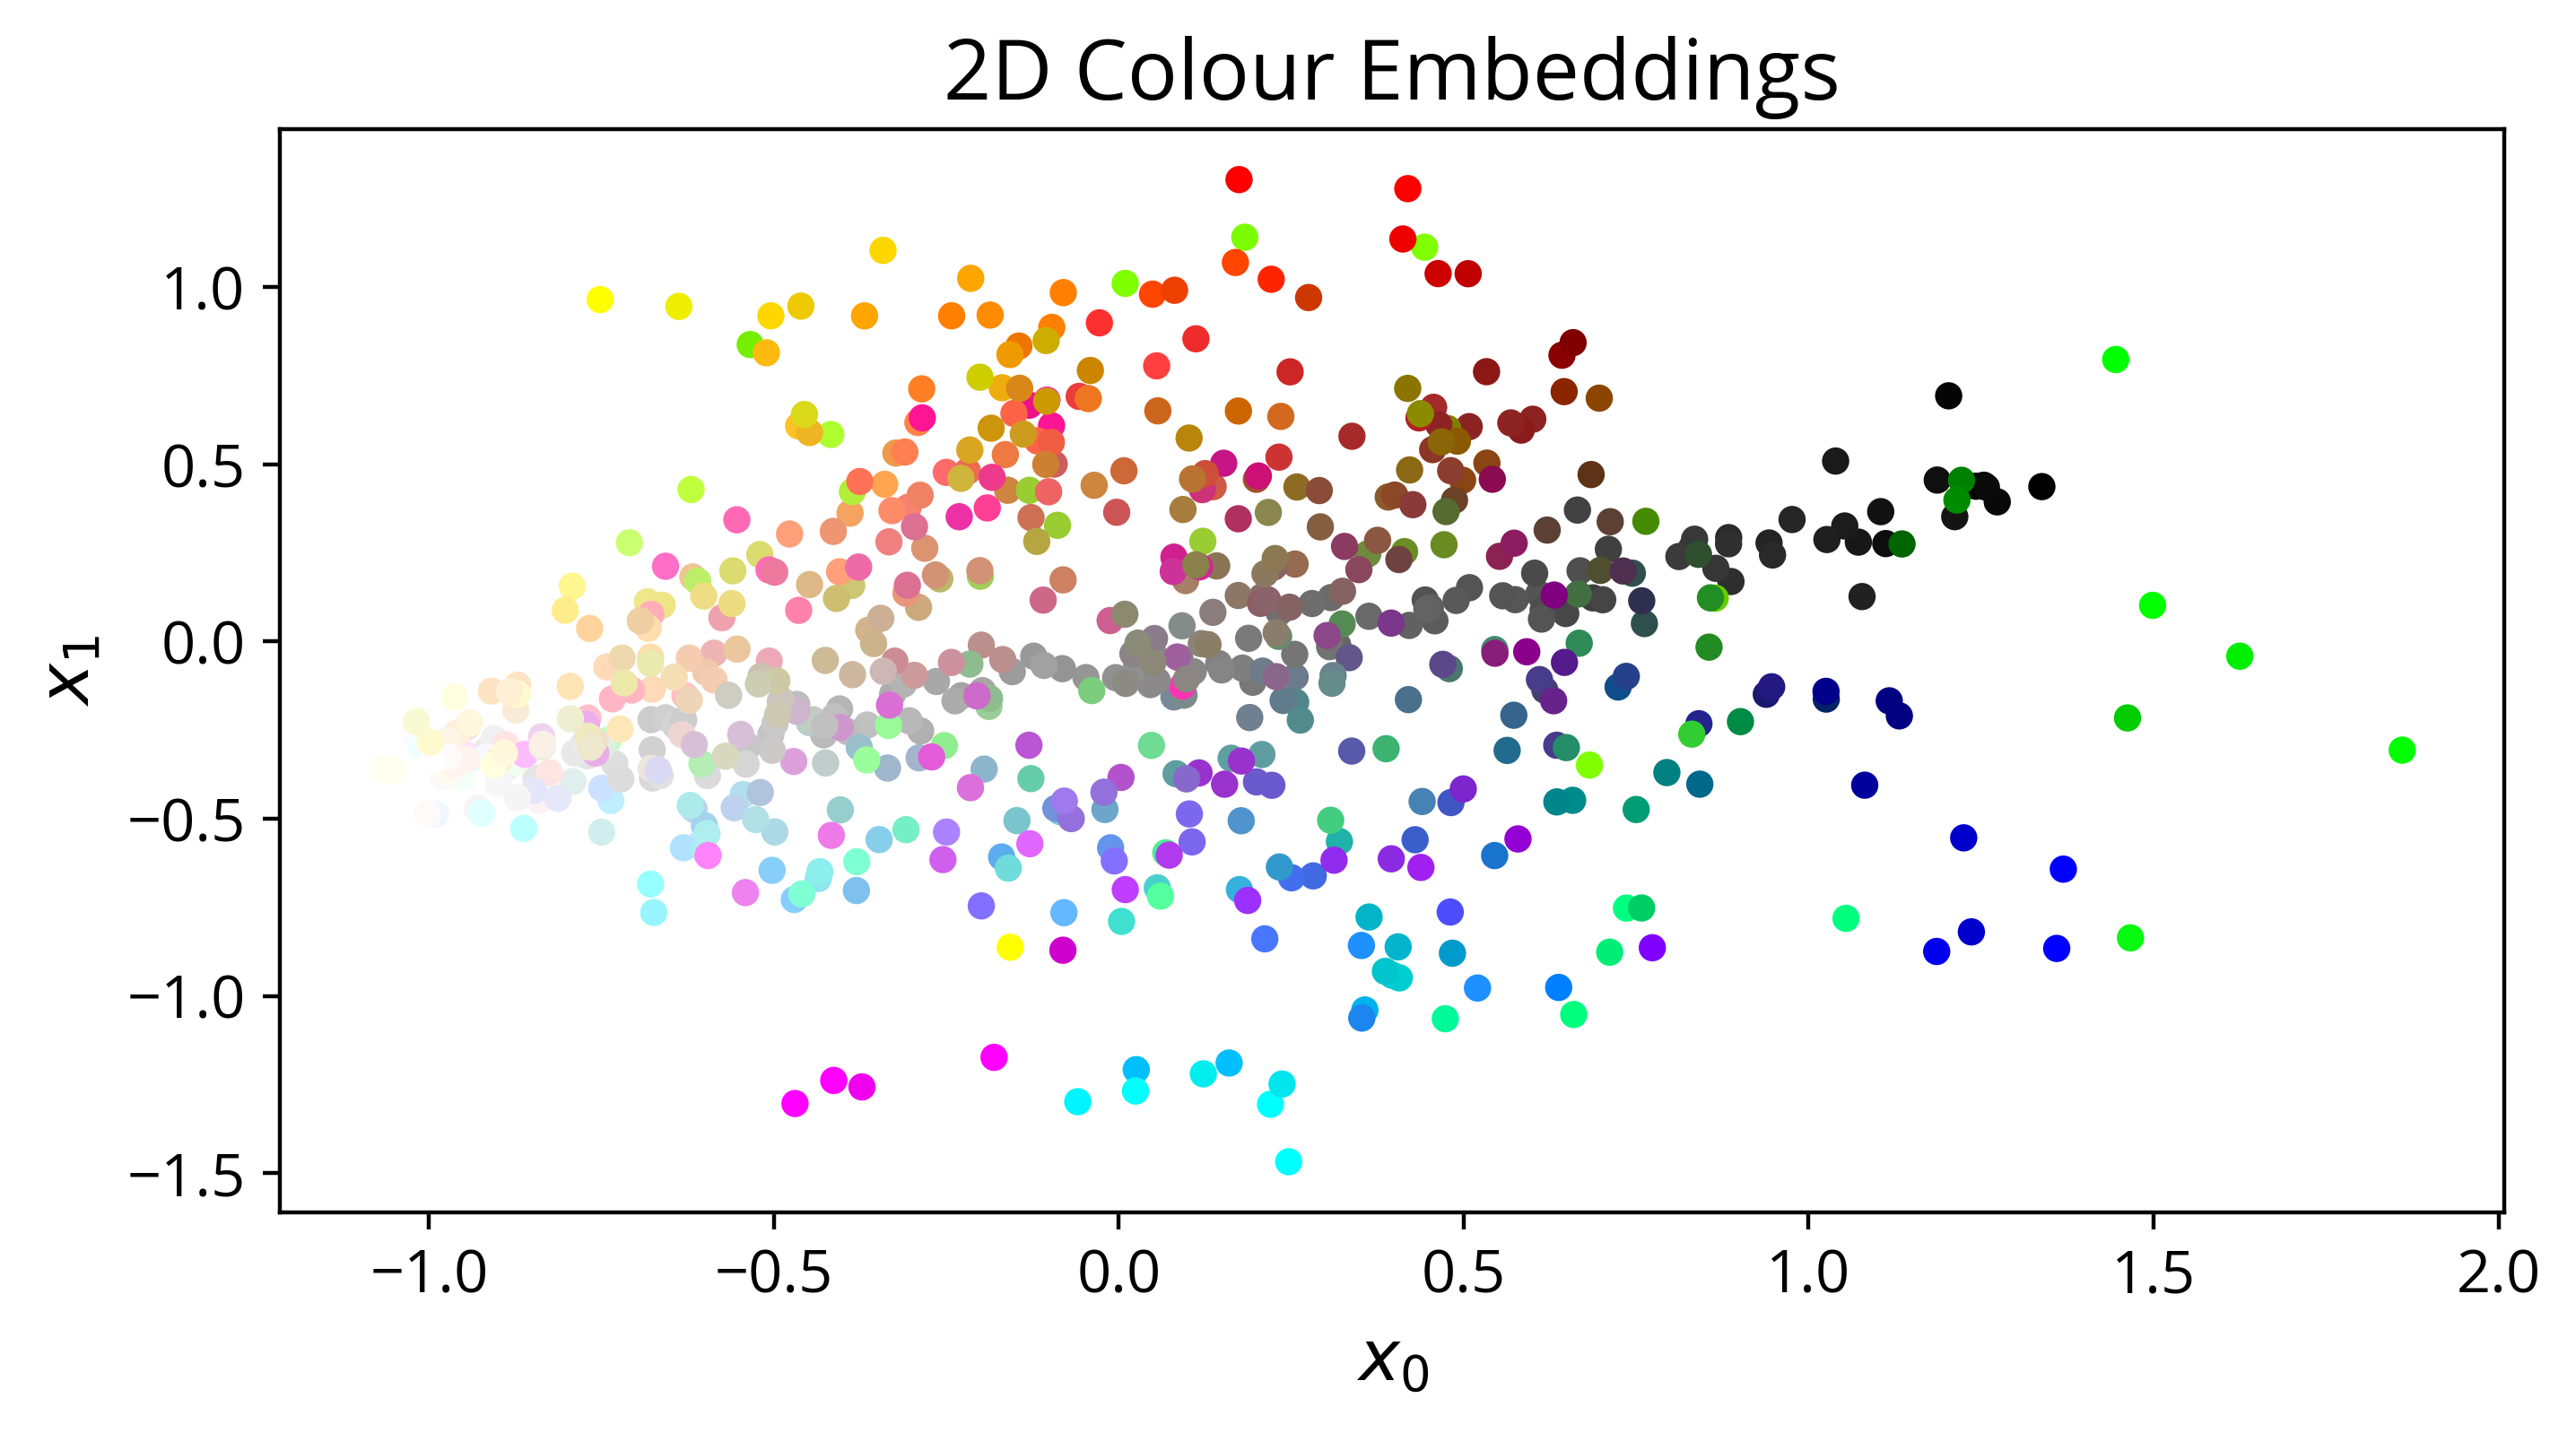

In [12]:
fig, ax = plt.subplots()
scat = ax.scatter(weights[-1][:, 0], weights[-1][:, 1], color=cs, s=20)
ax.set_xlabel("$x_0$"), ax.set_ylabel("$x_1$")
ax.set_title("2D Colour Embeddings");

!!!main

And thats it! The embeddings are trained, and we could now save them out and use them in a future model where - for some unknown reason, we need to ascribe numeric value to colour names, such that similar colours are close to each other in that vector space.

# 3D Embeddings

Just for fun, lets move to 3D space. Many embeddings are normalised such that the magnitude of each embedded vector is one, so I was tempted to do that for this example... but then we'd be back to a 2D surface (the surface of the unit sphere). So no normalisation for this, but if you wanted to know how to do it, I've redefined the model and commented out an `l2_normalize` layer, which would enforce unit vectors across arbitrary dimensions.


In [13]:
def get_model2(embedding_dims=3):
    model = keras.Sequential()
    model.add(Embedding(num_colours, embedding_dims, input_length=2))
    # model.add(Lambda(lambda x: K.l2_normalize(x, axis=-1), name="Norm"))
    model.add(Lambda(sum_dist, output_shape=(1,), name="Dist"))
    model.add(Dense(1, activation="sigmoid"))
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["mse"])
    return model

weights_3d = []
save = LambdaCallback(on_epoch_end=lambda batch, logs: 
                      weights_3d.append(model.layers[0].get_weights()[0]))
setseed(1)
model = get_model2()
model.fit(X, y, epochs=500, verbose=0, batch_size=512, callbacks=[save]);

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2, 3)              1938      
_________________________________________________________________
Dist (Lambda)                (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
None


And because the animation code for 3D plots is even uglier than the 2D, I've hidden it away. But here is the constrained 3D trained embeddings!

In [33]:
%%capture

from mpl_toolkits.mplot3d import Axes3D

w = np.array(weights_3d)
max_val = np.abs(w).max()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Training of 3D colour embeddings from colour pairs", fontsize=12)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.95)
# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = True
ax.w_xaxis.line.set_lw(0.)
ax.w_yaxis.line.set_lw(0.)
ax.w_zaxis.line.set_lw(0.)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.grid(False)

scat = ax.scatter(w[-1, :, 0], w[-1, :, 1], w[-1, :, 2], marker="o", alpha=1,
                  color=cs, facecolor=cs, edgecolor=None, lw=0, s=20, animated=True);

def init():
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)
    ax.set_zlim(-max_val, max_val)
    return scat,
def update(n, frames):
    i = frames[n]
    scat._offsets3d = w[i, :, 0], w[i, :, 1], w[i, :, 2]
    ax.view_init(elev=10., azim=2 * n)
    return scat,

n_weight = len(weights_3d) - 1
n_frames = 30 * 12
power = 2
frames = (np.linspace(1, n_weight**(1 / power), n_frames)**power).astype(int)
frames = pd.unique(frames)
iis = list(range(len(frames)))
ani3d = FuncAnimation(fig, update, frames=iis, fargs=(frames,), init_func=init, blit=True, interval=33.3);

In [ ]:
#HTML(ani3d.to_html5_video())
ani3d.save('encoding_colours/embed_3d.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
Video("encoding_colours/embed_3d.mp4")


And with the beauty of one more dimension, we can see that the RGB colour clusters can start to be separated independently.

# Summary

Hopefully in this small write up you've seen how we can train embeddings to map categorical features to a coordinate in vector space. In our specific example, we started with a colour dataset, and generated pairs of colours with a label of either 1 for "similar" or 0 for "dissimilar". We then managed to recover the relationship between colours by training an embedding only using this information.

If you want to read more on how to use embeddings in Keras, Jason Brownlee has some great write ups:

* [What are word embeddings for text?](https://machinelearningmastery.com/what-are-word-embeddings/)
* [How to Use Word Embeddings Layers for Deep Learning with Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
* [How to Develop Word Embeddings in Python with Gensim](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)

Have fun!